# Anomaly detection for time series

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd

from TSB_UAD.utils.max_mean_discrepancy import calculate_mmd
from TSB_UAD.utils.shapelets import calculate_shapelet_similarity
from TSB_UAD.utils.dtw import compute_dtw_distance

from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from sklearn.preprocessing import MinMaxScaler

from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.lof import LOF
from TSB_UAD.models.pca import PCA
from TSB_UAD.models.poly import POLY
from TSB_UAD.models.ocsvm import OCSVM
from TSB_UAD.models.lstm import lstm
from TSB_UAD.models.AE import AE_MLP2
from TSB_UAD.models.cnn import cnn
from TSB_UAD.models.custom_lstm import CustomLstm

##  Data preprocessing

Here we load and prepare the time series (here, we load only a snippet of 10,000 points). We asutomatically estimate the subsequence length for the anomaly detection methods that require a subsequence length parameter.
In order to do this, we use auto-correlation

In [2]:
# Prepare data for unsupervised method

filepath = 'data/TSB-UAD-Synthetic/YAHOO_add_point_outlier_0.02/Yahoo_A1real_1_data.out'
df = pd.read_csv(filepath, header=None).dropna().to_numpy()

name = filepath.split('/')[-1]
max_length = 10000

data = df[:max_length,0].astype(float)
label = df[:max_length,1].astype(int)
    
slidingWindow = find_length(data)
X_data = Window(window = slidingWindow).convert(data).to_numpy()


# Prepare data for semisupervised method. 
# Here, the training ratio = 0.1

data_train = data[:int(0.1*len(data))]
data_test = data

X_train = Window(window = slidingWindow).convert(data_train).to_numpy()
X_test = Window(window = slidingWindow).convert(data_test).to_numpy()

print("Estimated Subsequence length: ",slidingWindow)
print("Time series length: ",len(data))
print("Number of abnormal points: ",list(label).count(1))

Estimated Subsequence length:  24
Time series length:  1420
Number of abnormal points:  30


# Dataset similarity

Here we are demonstrating and experimenting with datasets that we are trying to find their similarities between them

In [3]:
filepath = 'data/TSB-UAD-Synthetic/YAHOO_add_point_outlier_0.02/Yahoo_A1real_2_data.out'
df2 = pd.read_csv(filepath, header=None).dropna().to_numpy()
name = filepath.split('/')[-1]
max_length = 10000

data2 = df2[:max_length,0].astype(float)
label2 = df2[:max_length,1].astype(int)

slidingWindow2 = find_length(data2)

print("Estimated Subsequence length: ",slidingWindow2)
print("Time series length: ",len(data2))
print("Number of abnormal points: ",list(label2).count(1))

Estimated Subsequence length:  71
Time series length:  1439
Number of abnormal points:  43


Use Maximum Mean Discrepancy (MMD) with an RBF kernel to compute pairwise similarities between datasets.

In [4]:
mmd_value = calculate_mmd(data, data2, gamma=1.0)
print("MMD value:", mmd_value)

MMD value: 0.9897098882612512


Use Dynamic Time Warping (DTW) to find time series alignment/similarity

In [5]:
dtw_value = compute_dtw_distance(data, data2)
print("DTW value:", dtw_value)

DTW value: 16945239.036


Shapelets are small, discriminative subsequences of a time series that can represent key patterns or features.

1. Extract shapelets from both datasets.
2. Calculate distances between shapelets from both datasets to measure similarity.

In [6]:
shapelet_value = calculate_shapelet_similarity(data, data2)
print('Shapelet similarity value:', shapelet_value)

Shapelet similarity value: nan


Experiments on a specified dataset, SensorScope. Here each time series is compared with the rest. As a result, with each time series we limit the total number of models that are required to be built

For example, we have 23 time series in the SensorScope dataset with an added outlier point. 

In [ ]:
directory = 'data/TSB-UAD-Synthetic/SensorScope_add_white_noise_1/'
files = [f for f in sorted(os.listdir(directory))]
print("Total number of time series:", len(files))

results = {'name':[], 'time_series_length': [], 'window_length':[], 'num_of_anomalies':[], 'ts_comparison_name':[], 'mmd_value':[], 'dwt_value':[], 'shapelet_similarity':[]}

In [ ]:
for i in range(0, len(files)-1):
    df1 = pd.read_csv(directory + files[i], header=None).dropna().to_numpy()
    # max_length = 10000

    data1 = df1[:,0].astype(float)
    label1 = df1[:,1].astype(int)

    slidingWindow1 = find_length(data1)

    df2 = pd.read_csv(directory + files[i+1], header=None).dropna().to_numpy()

    data2 = df1[:,0].astype(float)
    label2 = df1[:,1].astype(int)

    slidingWindow2 = find_length(data2)

    mmd_value = calculate_mmd(data1, data2, gamma=1.0)
    dtw_value = compute_dtw_distance(data1, data2)
    shapelet_value = calculate_shapelet_similarity(data1, data2)

    results['name'].append(files[i])
    results['time_series_length'].append(len(data1))
    results['window_length'].append(slidingWindow1)
    results['num_of_anomalies'].append(list(label1).count(1))
    results['ts_comparison_name'].append(files[i+1])
    results['mmd_value'].append(mmd_value)
    results['dwt_value'].append(dtw_value)
    results['shapelet_similarity'].append(shapelet_value)

    # print(files[i], mmd_value, dtw_value, shapelet_value)
    print('Time series', i, 'has completed')

In [ ]:
results_df = pd.DataFrame.from_dict(results)
# results_df.head()
results_df.to_csv('SensorScope_add_white_noise_1.csv')

In [ ]:
directory = 'data/TSB-UAD-Synthetic/SensorScope_add_white_noise_0.5/'
files = [f for f in sorted(os.listdir(directory))]
print("Total number of time series:", len(files))

results = {'name':[], 'time_series_length': [], 'window_length':[], 'num_of_anomalies':[], 'ts_comparison_name':[], 'mmd_value':[], 'dwt_value':[], 'shapelet_similarity':[]}

for i in range(0, len(files)):
    df1 = pd.read_csv(directory + files[i], header=None).dropna().to_numpy()
    # max_length = 10000

    data1 = df1[:,0].astype(float)
    label1 = df1[:,1].astype(int)

    slidingWindow1 = find_length(data1)

    for j in range(0, len(files)):
        df2 = pd.read_csv(directory + files[j], header=None).dropna().to_numpy()

        data2 = df1[:,0].astype(float)
        label2 = df1[:,1].astype(int)

        slidingWindow2 = find_length(data2)

        mmd_value = calculate_mmd(data1, data2, gamma=1.0)
        dtw_value = compute_dtw_distance(data1, data2)
        shapelet_value = calculate_shapelet_similarity(data1, data2)

        results['name'].append(files[i])
        results['time_series_length'].append(len(data1))
        results['window_length'].append(slidingWindow1)
        results['num_of_anomalies'].append(list(label1).count(1))
        results['ts_comparison_name'].append(files[j])
        results['mmd_value'].append(mmd_value)
        results['dwt_value'].append(dtw_value)
        results['shapelet_similarity'].append(shapelet_value)

        # print(files[i], mmd_value, dtw_value, shapelet_value)
        print('Time series', j, 'has completed')

results_df = pd.DataFrame.from_dict(results)
# results_df.head()
results_df.to_csv('SensorScope_add_white_noise_05.csv', sep=';')
print('File saved')

## Display the results of anomaly detectors

For each output figure, the left panel shows the real time series with outliers (red), anomaly score obtained by each anomaly detector, and the correpsonding TP/FP/TN/FN classification. 

The right panel shows the ROC curve. AUC represents the area under the ROC curve. Larger AUC indicates better performance.

34 34
51 51
108 108
235 236
253 253
269 269
386 386
395 395
427 427
573 573
583 583
615 615
707 707
742 742
776 776
795 795
810 810
814 814
842 842
992 992
1031 1031
1121 1121
1171 1171
1201 1201
1214 1214
1216 1216
1240 1240
1260 1260
1267 1267
1205 1236
1320 1320


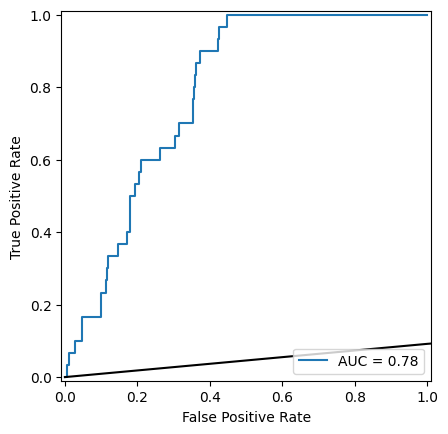

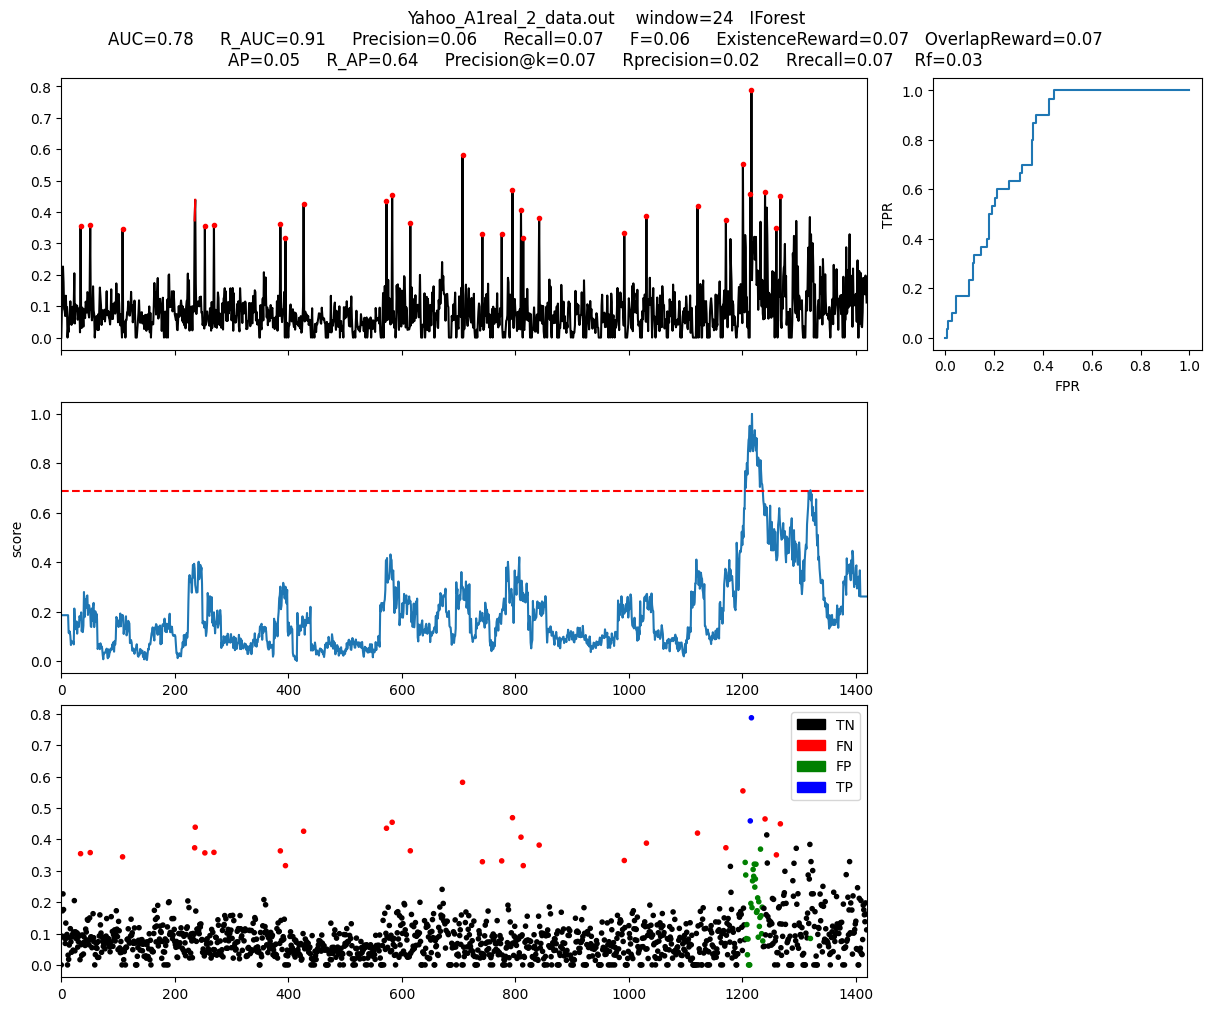

In [8]:
modelName='IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

34 34
51 51
108 108
235 236
253 253
269 269
386 386
395 395
427 427
573 573
583 583
615 615
707 707
742 742
776 776
795 795
810 810
814 814
842 842
992 992
1031 1031
1121 1121
1171 1171
1201 1201
1214 1214
1216 1216
1240 1240
1260 1260
1267 1267
1204 1224
1251 1252


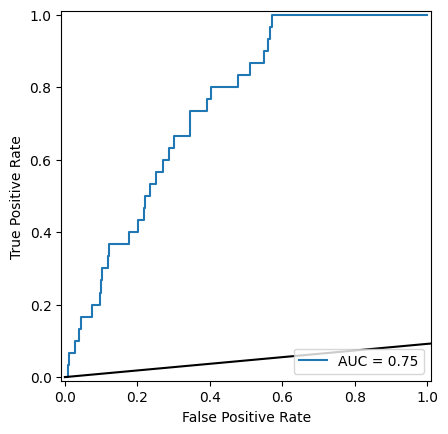

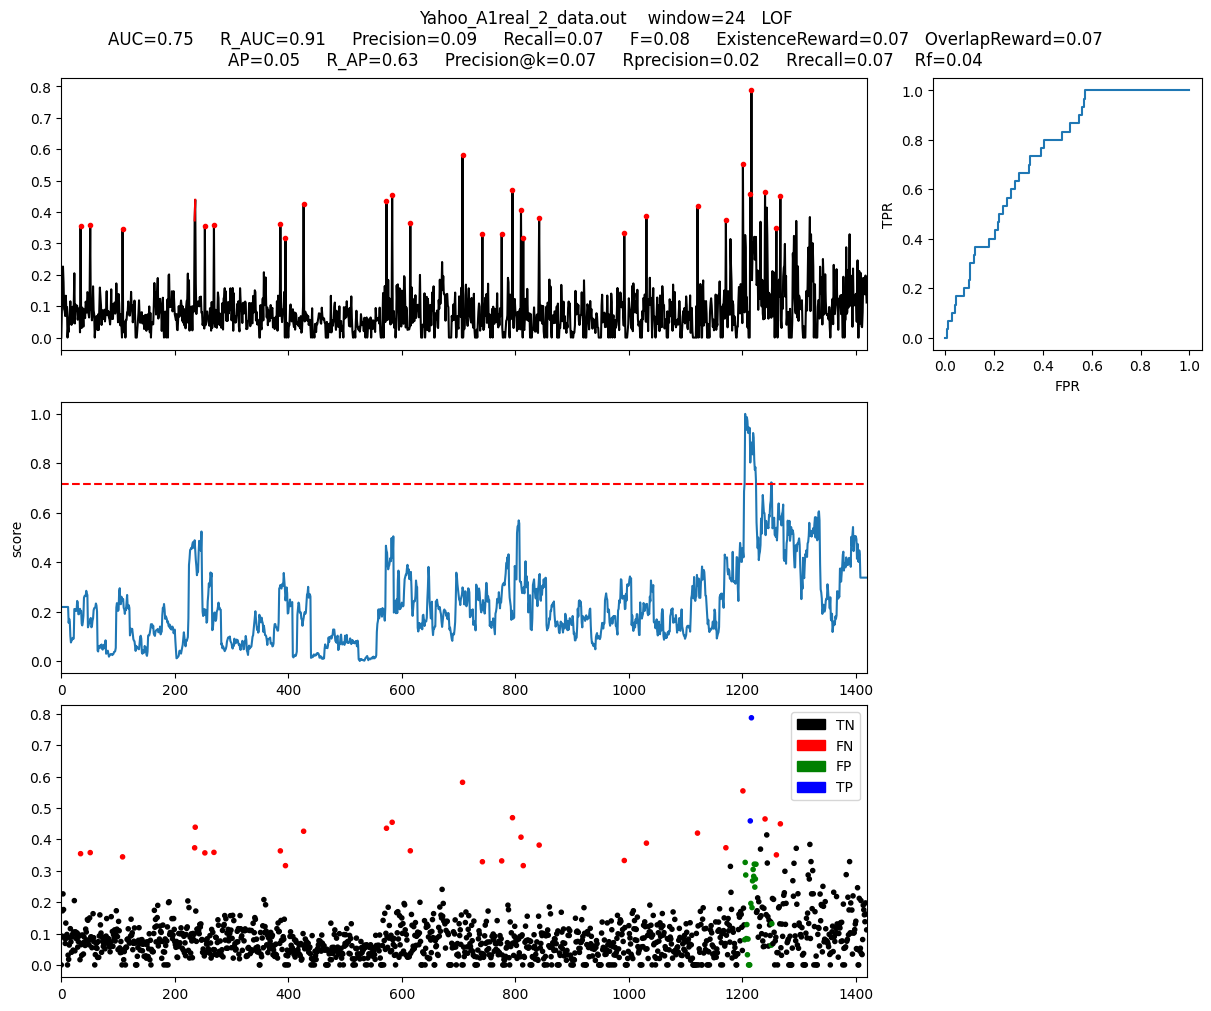

In [9]:
modelName='LOF'
clf = LOF(n_neighbors=20, n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

34 34
51 51
108 108
235 236
253 253
269 269
386 386
395 395
427 427
573 573
583 583
615 615
707 707
742 742
776 776
795 795
810 810
814 814
842 842
992 992
1031 1031
1121 1121
1171 1171
1201 1201
1214 1214
1216 1216
1240 1240
1260 1260
1267 1267
1205 1228


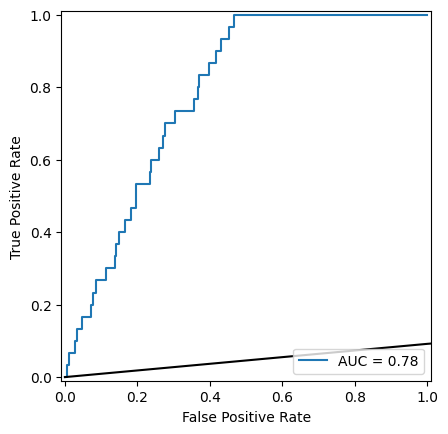

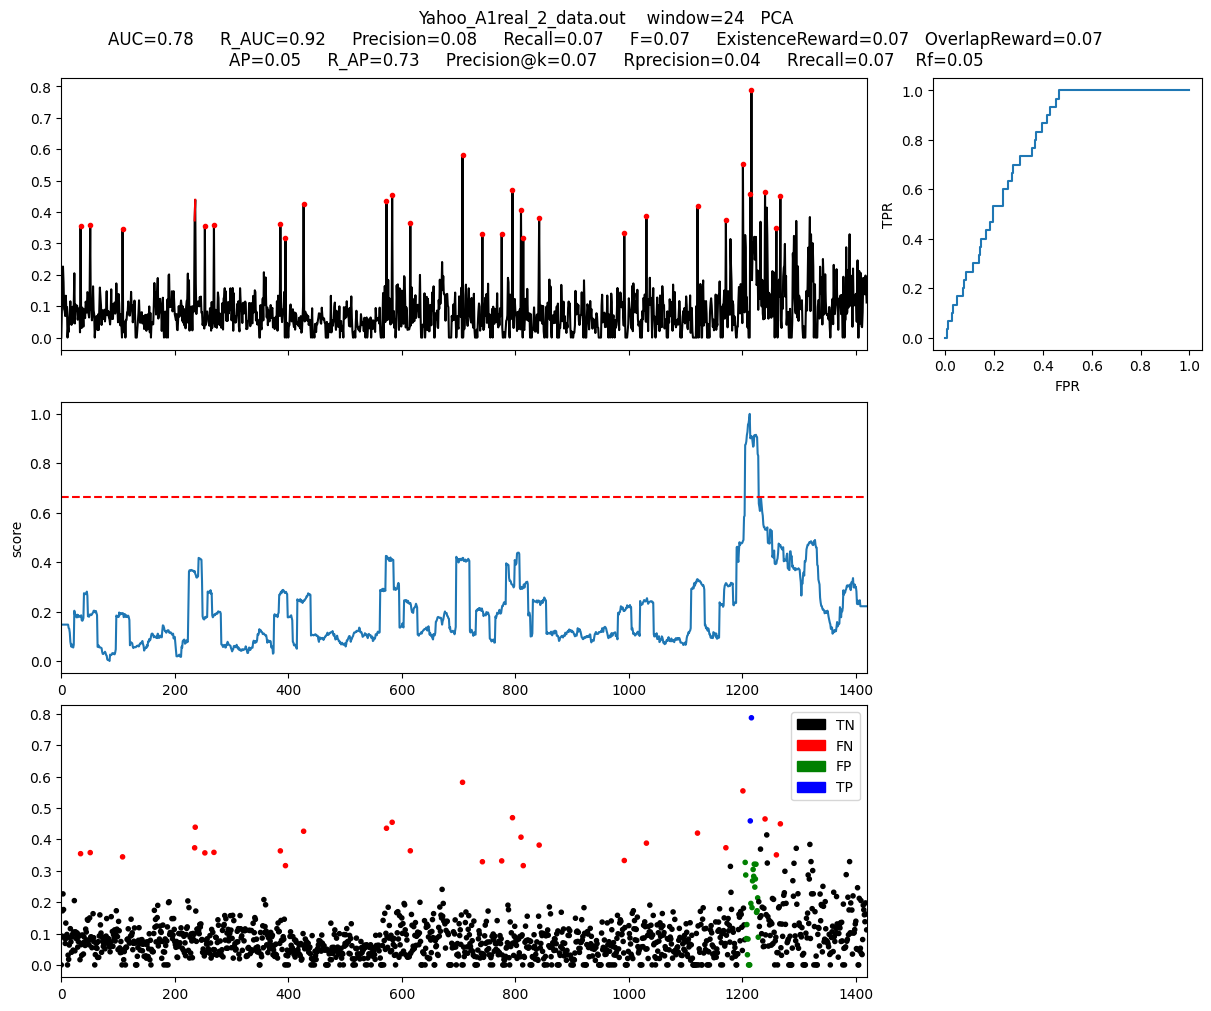

In [10]:
modelName='PCA'
clf = PCA()
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

34 34
51 51
108 108
235 236
253 253
269 269
386 386
395 395
427 427
573 573
583 583
615 615
707 707
742 742
776 776
795 795
810 810
814 814
842 842
992 992
1031 1031
1121 1121
1171 1171
1201 1201
1214 1214
1216 1216
1240 1240
1260 1260
1267 1267
1200 1223


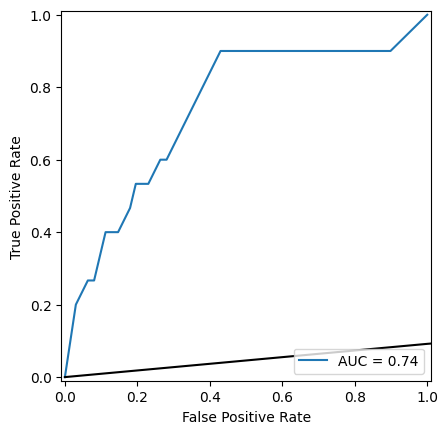

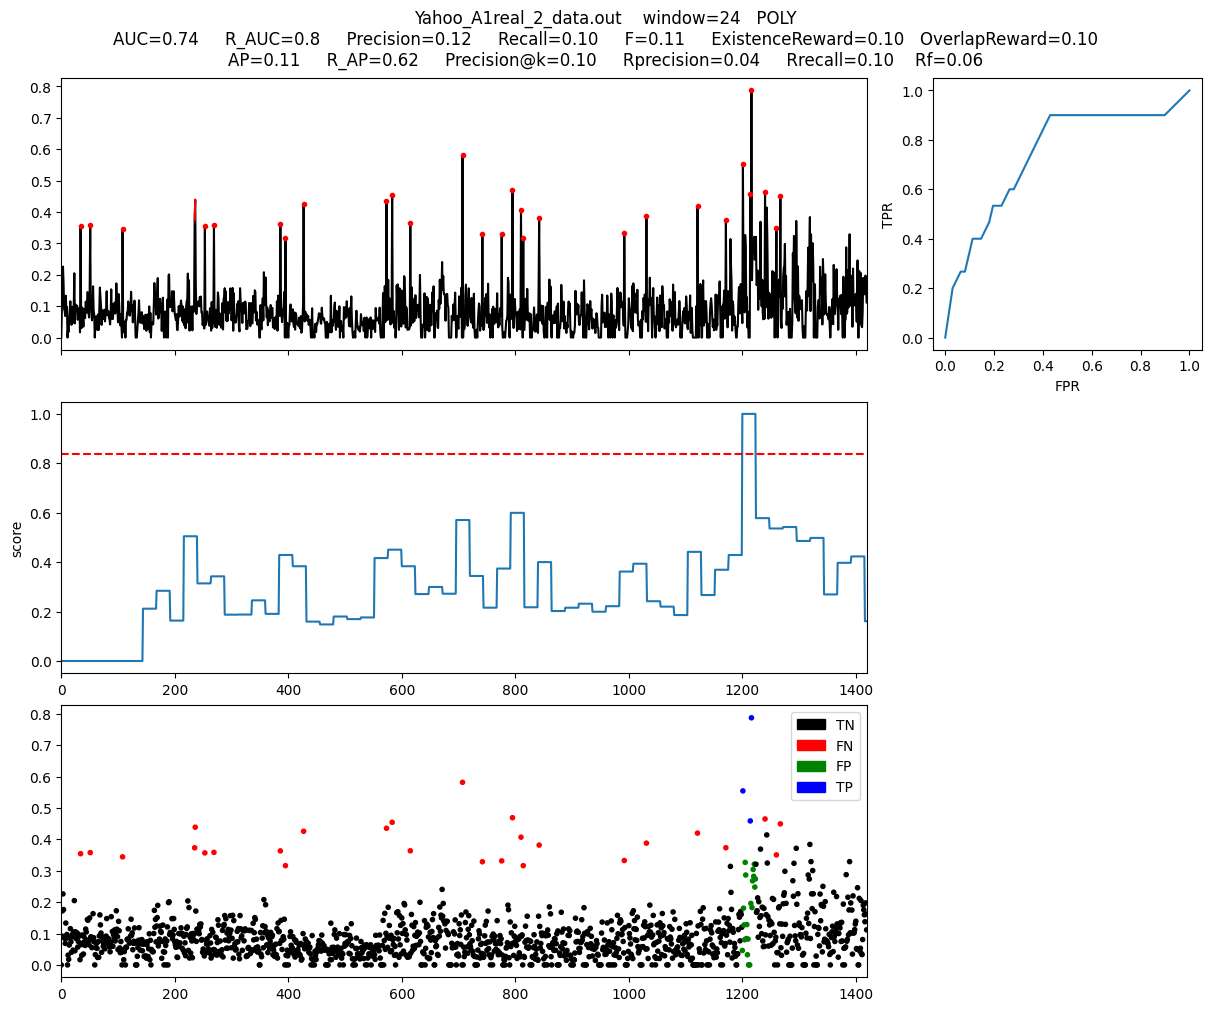

In [11]:
modelName='POLY'
clf = POLY(power=3, window = slidingWindow)
x = data
clf.fit(x)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

34 34
51 51
108 108
235 236
253 253
269 269
386 386
395 395
427 427
573 573
583 583
615 615
707 707
742 742
776 776
795 795
810 810
814 814
842 842
992 992
1031 1031
1121 1121
1171 1171
1201 1201
1214 1214
1216 1216
1240 1240
1260 1260
1267 1267
293 294
296 296
539 539
541 542
686 688
690 690


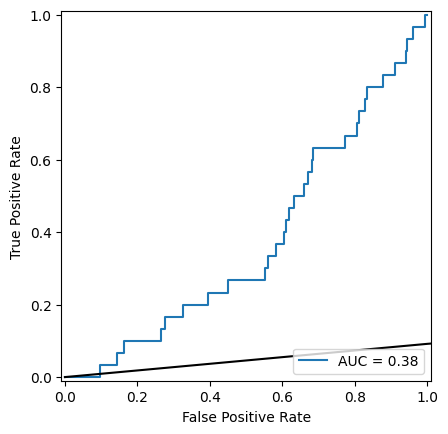

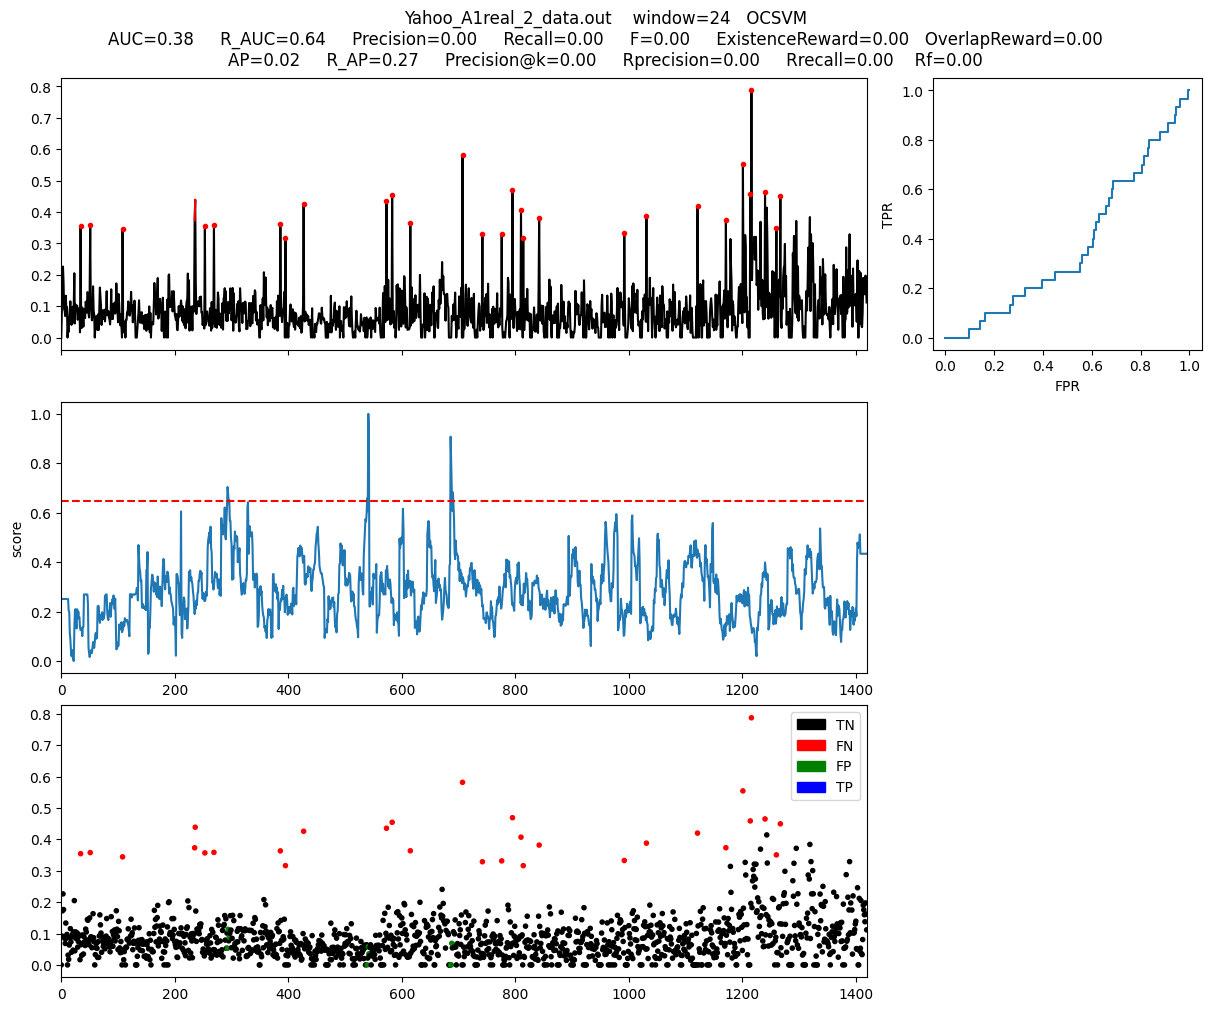

In [12]:
modelName='OCSVM'
X_train_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_train.T).T
X_test_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_test.T).T

clf = OCSVM(nu=0.05)
clf.fit(X_train_, X_test_)


score = clf.decision_scores_
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
34 34
51 51
108 108
235 236
253 253
269 269
386 386
395 395
427 427
573 573
583 583
615 615
707 707
742 742
776 776
795 795
810 810
814 814
842 842
992 992
1031 1031
1121 1121
1171 1171
1201 1201
1214 1214
1216 1216
1240 1240
1260 1260
1267 1267
34 34
51 51
97 97
108 108
164 164
189 190
223 223
235 236
269 269
357 357
386 386
427 427
475 475
567 567
570 570
573 573
583 583
615 615
707 707
742 742
776 776
795 795
841 842
906 906
953 953
980 980
992 992
1031 1031
1121 1121
1171 1171
1201 1201
1216 1216
1267 1267
1295 1295
1319 1319
1383 1383
1389 1389


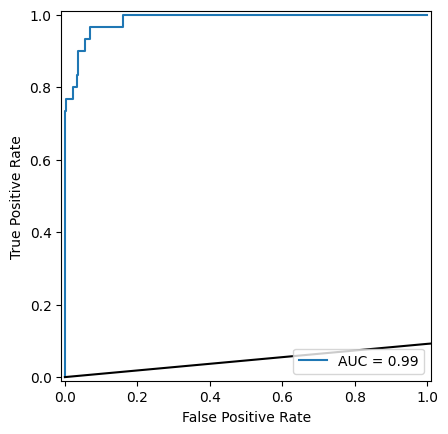

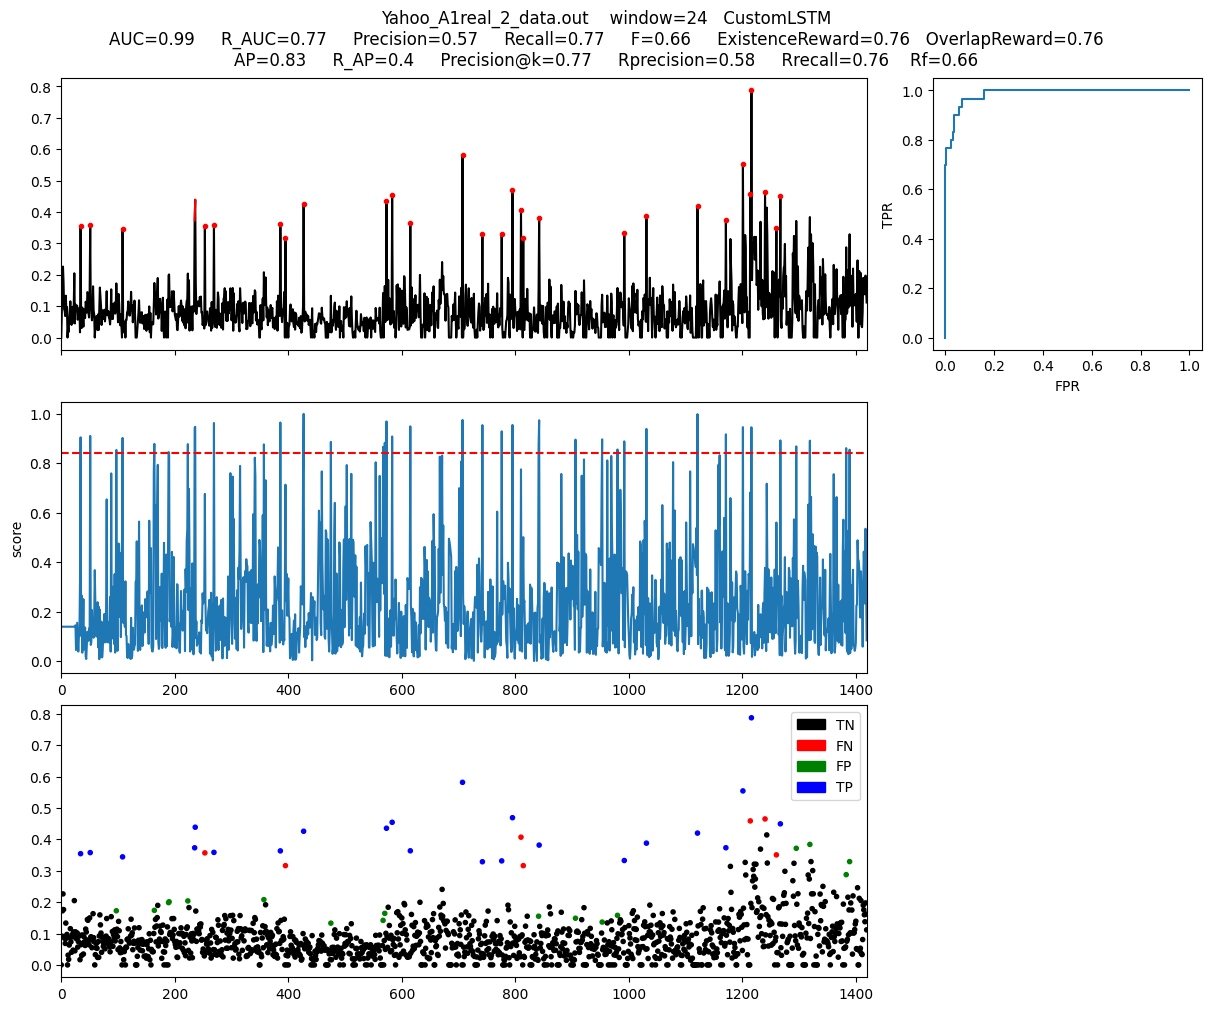

In [13]:
modelName='CustomLSTM'
clf = CustomLstm(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
34 34
51 51
108 108
235 236
253 253
269 269
386 386
395 395
427 427
573 573
583 583
615 615
707 707
742 742
776 776
795 795
810 810
814 814
842 842
992 992
1031 1031
1121 1121
1171 1171
1201 1201
1214 1214
1216 1216
1240 1240
1260 1260
1267 1267
64 71
77 77
96 96
121 121
124 134
136 145
147 152
163 169
171 176
178 178
186 193
196 197
199 200
203 205
207 207
211 211
285 302
304 314
321 321
328 329
331 333
339 340
342 344
373 373
408 412
415 415
444 463
489 503
526 527
529 553
596 601
652 652
655 655
658 659
663 670
672 673
686 688
690 692
934 936
976 980
1005 1010
1017 1019
1046 1046
1049 1055
1061 1065
1067 1067
1070 1071
1096 1102
1147 1148
1337 1339
1367 1369
1403 1419


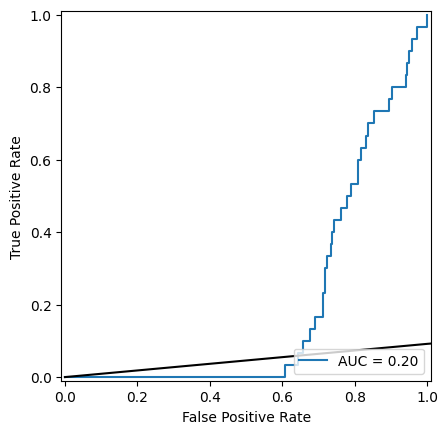

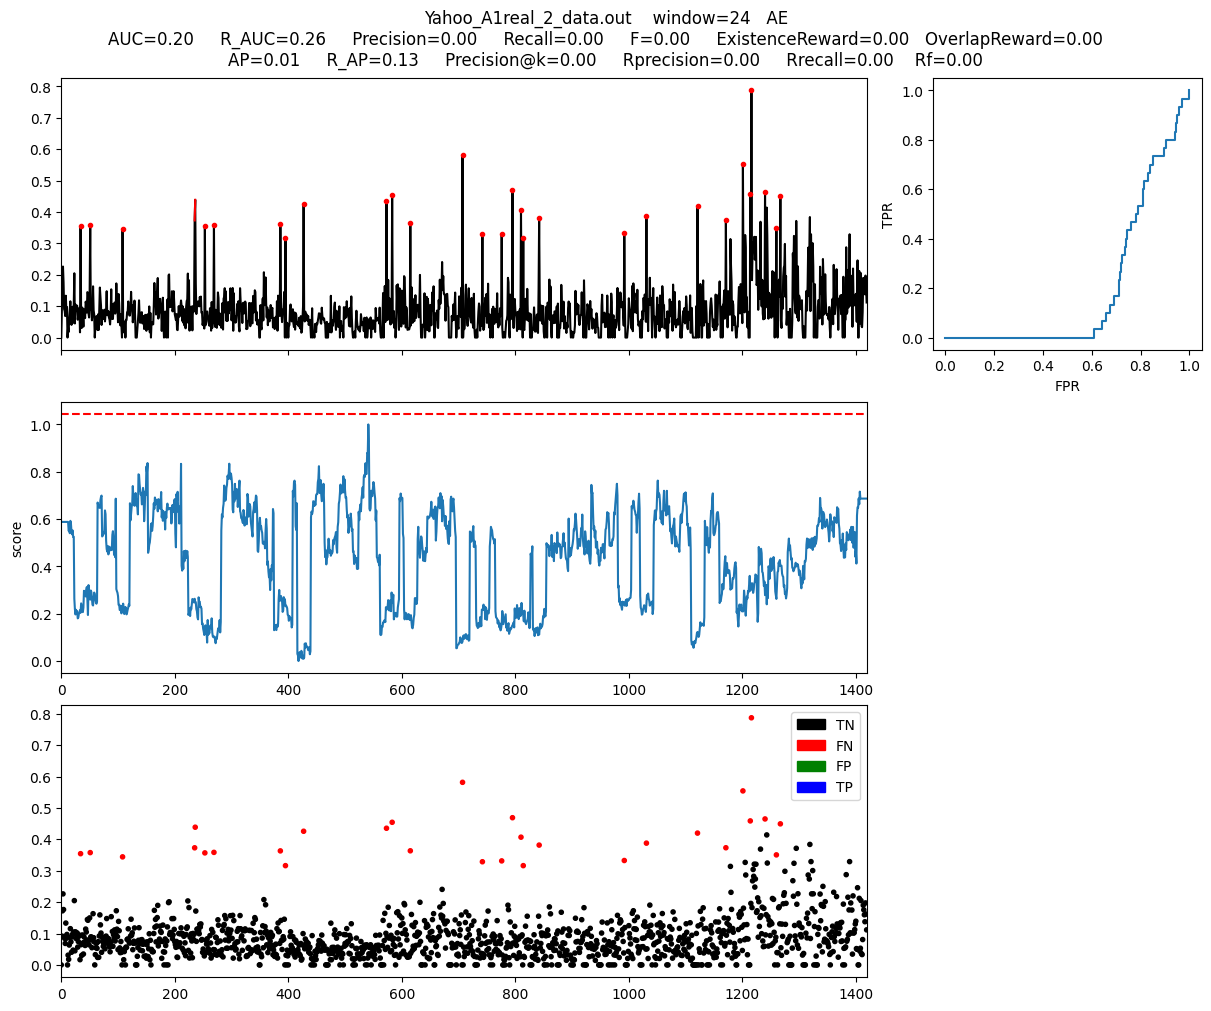

In [14]:
modelName='AE'
clf = AE_MLP2(slidingWindow = slidingWindow, epochs=100, verbose=0)

clf.fit(data_train, data_test)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
34 34
51 51
108 108
235 236
253 253
269 269
386 386
395 395
427 427
573 573
583 583
615 615
707 707
742 742
776 776
795 795
810 810
814 814
842 842
992 992
1031 1031
1121 1121
1171 1171
1201 1201
1214 1214
1216 1216
1240 1240
1260 1260
1267 1267
34 34
51 51
108 108
164 164
170 170
189 189
223 223
235 236
386 386
427 427
475 475
561 561
567 567
570 570
573 573
615 615
671 671
707 707
742 742
776 776
795 795
842 842
921 921
992 992
1031 1031
1108 1108
1121 1121
1171 1171
1201 1201
1216 1216
1267 1267
1319 1319
1383 1383
1389 1389


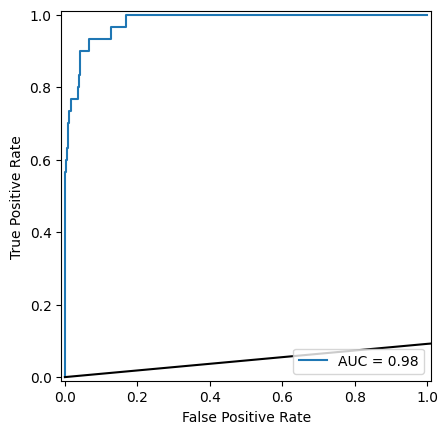

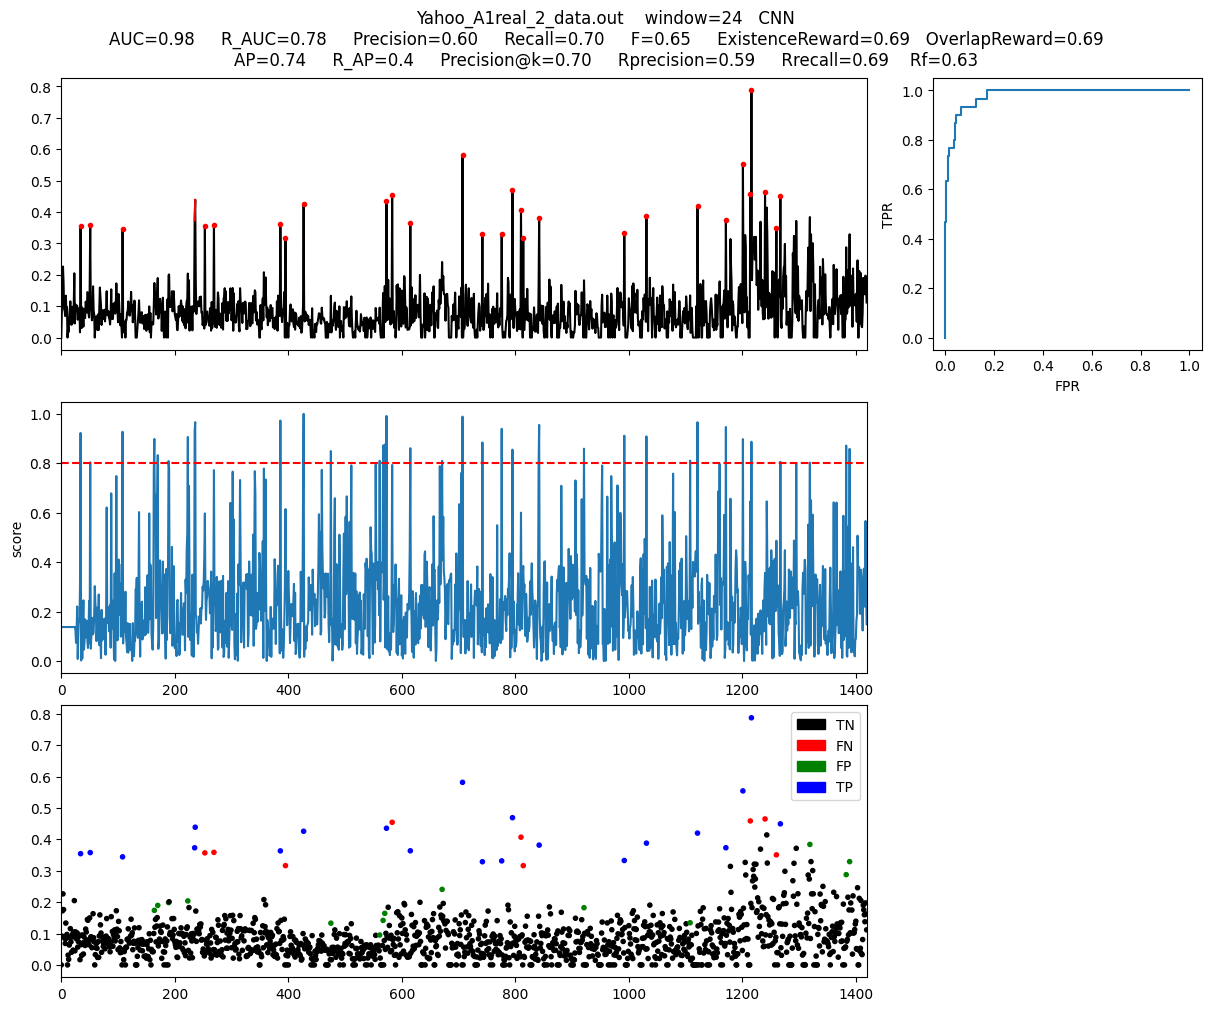

In [15]:
modelName='CNN'
clf = cnn(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 100, patience = 5, verbose=0)

clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)